In [1]:
import os
import gc
import re

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import wordcloud

from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
# !pip install pyarrow
# !pip install nltk
# !pip install wordcloud
# !pip install xgboost

In [4]:
# train = pd.read_csv('c:/data/project/train.csv')
# test = pd.read_csv('c:/data/project/test.csv')

## Data Preprocessing

In [2]:
# # parquet으로 저장 함수, csv보다 매우 빠르게 데이터 처리가 가능합니다 :)
## Convert CSV files to Parquet format for faster data reading and processing
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()                            #garbage collect
    print(save_name, 'Done.')

In [3]:
csv_to_parquet('c:/data/project/train.csv', 'train')
csv_to_parquet('c:/data/project/test.csv', 'test')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
# sample_submission = pd.read_csv('c:/data/project/sample_submission.csv', index_col = 0)

train Done.
test Done.


In [4]:
# train 복사
train1 = train.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [5]:
train1.drop(columns=['ID','first_party', 'second_party'], inplace=True)

In [7]:
print(train1['first_party_winner'].value_counts())
train1.head()

first_party_winner
1    1649
0     829
Name: count, dtype: int64


,facts,first_party_winner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,"On April 24, 1953 in Selma, Alabama, an intrud...",1


## 자연어처리

In [9]:

df = train1[['facts', 'first_party_winner']]
df_target = df[['first_party_winner']]

df_nlp = pd.DataFrame(df[['facts']], columns=['facts'])
# df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True) # 특수문자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'\d', '', regex=True)       # 숫자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'[^\w\s]', '', regex=True)

df_nlp

,facts
0,On June Phil St Amant a candidate for public...
1,Ramon Nelson was riding his bike when he suffe...
2,An Alabama state court convicted Billy Joe Mag...
3,Victor Linkletter was convicted in state court...
4,On April in Selma Alabama an intruder broke ...
...,...
2473,Congress amended the Clean Air Act through the...
2474,Alliance Bond Fund Inc an investment fund purc...
2475,In the District Court sentenced Manuel D Pegu...
2476,On March Enrico St Cyr a lawful permanent re...


In [10]:
df_target.value_counts()

first_party_winner
1                     1649
0                      829
Name: count, dtype: int64

In [12]:
# import nltk
# nltk.download()

In [12]:
# from nltk.tokenize import WhitespaceTokenizer
# # 공백 단위로 쪼개기
# corpus = df_nlp1["facts"]
# Tokenizer=WhitespaceTokenizer()
# lst_tokens = Tokenizer.tokenize(str(corpus))
# lst_tokens

In [14]:

# 사용자 불용어 + 기본 제공 불용어 생성
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, user_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    if user_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    user_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [81]:
# 사용자 불용어 제작
user_stopwords = set(["appeal","filed","affirmed","held","u","state","supreme","federal","circuit","district", "law", "court", "case", "plaintiff", "defendant",
                "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding",
                "litigation", "party", "motion", "action", "suit", "claim", "issue",
                "fact", "hearing", "judgment", "order", "allegation", "argument",
                "brief", "charge", "complaint", "contract", "crime", "decision", "defense",
                "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal",
                "liability", "matter", "notice", "opinion", "plea", "point", "policy", "practice",
                "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict",
                'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph"
                "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation",
                "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty",
                "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal",
                "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation",
                "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule",
                "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment",
                "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal",
                "bail", "contempt", "conviction", "felony", "parole", "sentence",
                "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor",
                "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor",
                "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer",
                "insured", "beneficiary", "fiduciary", "principal", "agent"])

In [76]:
# NLTK가 제공 기본 불용어
lst_stopwords = nltk.corpus.stopwords.words("english")

In [82]:
len(user_stopwords)

153

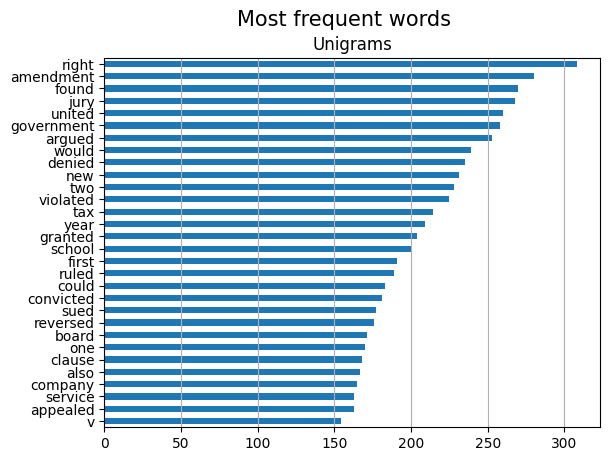

<Figure size 3000x2400 with 0 Axes>

In [83]:
df_nlp["facts_clean"] = df_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
df_nlp2 = df_nlp.join(df_target)
def freq(n):
    corpus = df_nlp2[df_nlp2["first_party_winner"]== n]["facts_clean"]
    temp = corpus.str.cat(sep=" ")
    wdTmp = utils_preprocess_text(temp, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords)
    lst_tokens = nltk.tokenize.word_tokenize(wdTmp)
    fig, ax = plt.subplots(1, 1)
    fig.suptitle("Most frequent words", fontsize=15)
    figure(figsize=(30, 24))
    
    ## unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(
                        kind="barh", title="Unigrams", ax=ax, 
                        legend=False).grid(axis='x')

    ax.set(ylabel=None)
    plt.show()

    # n회 미만 단어 제거
    newL = []
    for word, freq in dic_words_freq.most_common():
        if freq <= 2:
            newL.append(word)
    user_stopwords.update(newL)
        
    return newL

lost = freq(0)

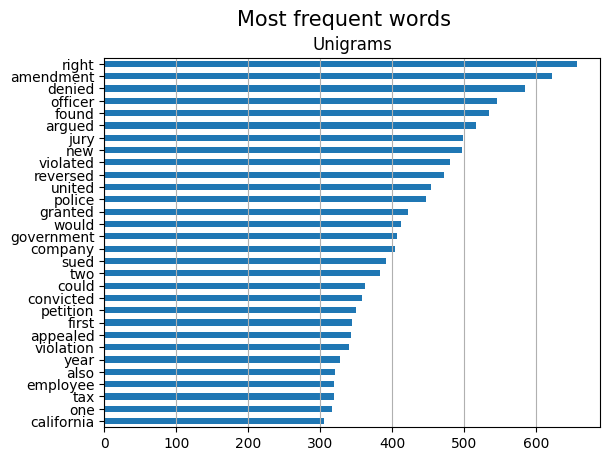

<Figure size 3000x2400 with 0 Axes>

In [87]:
won = freq(1)

In [88]:
len(user_stopwords)

10916

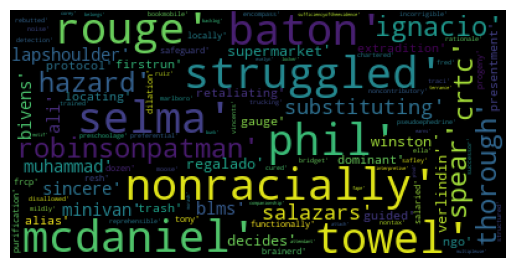

In [72]:
# import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc = wc.generate(str(won))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

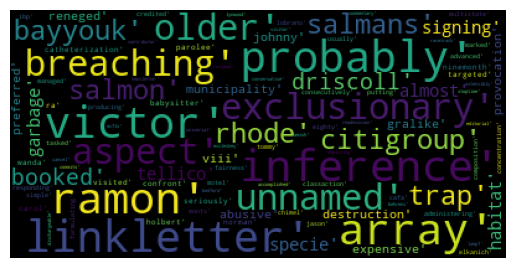

In [73]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc0 = wc0.generate(str(lost))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

## Preprocessing ENDS && MODELING STARTS

In [74]:
df_nlp2
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [89]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.3)

In [90]:
X_train.count(), X_test.count(), y_train.count(), y_test.count()

(1734, 744, 1734, 744)

In [91]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#REGRESSION

In [92]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [93]:
lr.score(X_test, y_test)

0.6505376344086021

#XGBoost

In [34]:
# !pip install xgboost

In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
                    booster = 'gbtree',
                    scale_pos_weight=0.25,
                    learning_rate=0.01,  
                    colsample_bytree = 0.7,
                    subsample = 0.5,
                    max_delta_step = 3,
                    reg_lambda = 2,
                    objective='binary:logistic',
                    n_estimators=818, 
                    max_depth=8,
                    )


xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=818, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [99]:

y_pred = xgb.predict_proba(X_test)
y_pred

array([[0.4329545 , 0.5670455 ],
       [0.5603191 , 0.43968087],
       [0.4410084 , 0.5589916 ],
       ...,
       [0.74271154, 0.25728846],
       [0.7873199 , 0.21268009],
       [0.73309684, 0.2669032 ]], dtype=float32)

In [109]:

xgb.score(X_test, y_test)

0.5040322580645161

In [111]:

tfidfv = TfidfVectorizer().fit(train['facts'])
print(tfidfv.vocabulary_)
print("="*100)
print(tfidfv.transform(train['facts']).toarray())
print("="*100)
print(tfidfv.fit_transform(train['facts']).toarray())
tfidfv

{'on': 11300, 'june': 8968, '27': 352, '1962': 233, 'phil': 11996, 'st': 14991, 'amant': 1383, 'candidate': 2920, 'for': 6763, 'public': 12745, 'office': 11251, 'made': 9834, 'television': 15696, 'speech': 14902, 'in': 8202, 'baton': 2158, 'rouge': 13907, 'louisiana': 9745, 'during': 5518, 'this': 15846, 'accused': 922, 'his': 7811, 'political': 12180, 'opponent': 11342, 'of': 11235, 'being': 2243, 'communist': 3652, 'and': 1456, 'involved': 8711, 'criminal': 4314, 'activities': 972, 'with': 17250, 'the': 15798, 'head': 7642, 'local': 9656, 'teamsters': 15662, 'union': 16453, 'finally': 6612, 'implicated': 8153, 'herman': 7738, 'thompson': 15850, 'an': 1433, 'east': 5570, 'deputy': 4845, 'sheriff': 14489, 'scheme': 14152, 'to': 15937, 'move': 10652, 'money': 10553, 'between': 2321, 'successfully': 15317, 'sued': 15326, 'defamation': 4640, 'first': 6651, 'circuit': 3355, 'court': 4233, 'appeals': 1564, 'reversed': 13694, 'holding': 7848, 'that': 15797, 'did': 5001, 'not': 11076, 'show':

TfidfVectorizer()

   Probability of Negative Class  Probability of Positive Class
0                       0.432954                       0.567046
1                       0.560319                       0.439681
2                       0.441008                       0.558992
3                       0.769246                       0.230754
4                       0.177404                       0.822596


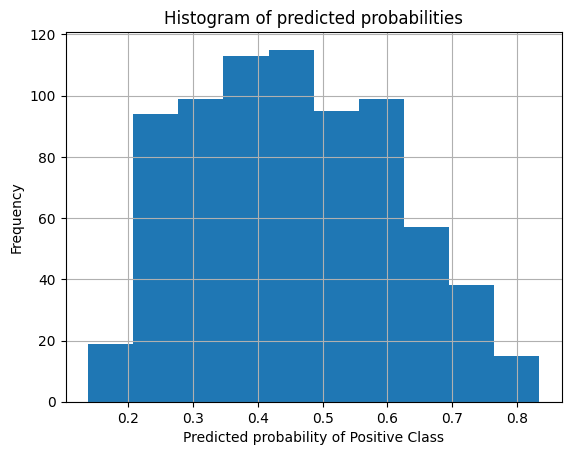

In [112]:
# Convert prediction results to a DataFrame
df_pred = pd.DataFrame(y_pred, columns=['Probability of Negative Class', 'Probability of Positive Class'])

# Print the first few rows
print(df_pred.head())

# Plot a histogram of probabilities for the positive class
df_pred['Probability of Positive Class'].hist()
plt.xlabel('Predicted probability of Positive Class')
plt.ylabel('Frequency')
plt.title('Histogram of predicted probabilities')
plt.show()


In [120]:
# Convert tf-idf array to DataFrame
df_tfidf = pd.DataFrame(tfidfv.transform(train['facts']).toarray(), columns=tfidfv.get_feature_names_out())
data_final = pd.concat([df_tfidf,df_nlp2["first_party_winner"]],axis=1,join='inner')
# print(df_tfidf.head())
terms = tfidfv.get_feature_names_out()
data_final

,00,000,0029,01,0136,019,027,03,032,04,...,zivotofsky,zone,zoned,zones,zoning,zubik,zuni,zurich,zurko,first_party_winner
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2474,0.0,0.046666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2475,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2476,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [121]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']), data_final['first_party_winner'], test_size=0.3,random_state=0)

In [122]:
# LDA 학습, 단어의 의미구조 파악
# 30초정도 걸림
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=1) # n_component : 토픽 갯수
lda_data = lda.fit_transform(X_train)

In [124]:
# LDA 학습 결과 보기

def get_topics(components, feature_names, n=5): # n: n개 출력
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda.components_,terms)

# 결과값은 토픽과 토픽의 기여도에 대한 데이터

Topic 1: [('ford', 0.71), ('cwa', 0.54), ('mcburney', 0.53), ('nea', 0.51), ('archers', 0.5)]
Topic 2: [('texas', 1.46), ('procedural', 1.11), ('remain', 1.02), ('tailored', 0.99), ('portion', 0.97)]
Topic 3: [('rape', 0.57), ('wilson', 0.55), ('perkins', 0.54), ('fpc', 0.52), ('thereafter', 0.52)]
Topic 4: [('stock', 1.56), ('policies', 1.07), ('sec', 0.9), ('1934', 0.85), ('amgen', 0.74)]
Topic 5: [('perry', 0.71), ('adelaide', 0.53), ('tolling', 0.51), ('brady', 0.5), ('equitable', 0.45)]
Topic 6: [('anza', 0.64), ('alice', 0.62), ('fox', 0.47), ('crenshaw', 0.45), ('kelly', 0.42)]
Topic 7: [('gray', 0.72), ('agee', 0.69), ('lindh', 0.61), ('cleveland', 0.59), ('fletcher', 0.56)]
Topic 8: [('surgery', 0.69), ('science', 0.6), ('fee', 0.59), ('creation', 0.55), ('utah', 0.5)]
Topic 9: [('chavis', 0.77), ('mcdonough', 0.69), ('davis', 0.59), ('ortiz', 0.55), ('clayton', 0.5)]
Topic 10: [('rummel', 0.67), ('supervisor', 0.6), ('bruton', 0.57), ('crawford', 0.55), ('evans', 0.52)]
Topic

In [153]:
# XG부스트 모델 적용하기
from sklearn.metrics import accuracy_score
# param_dict = {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300}
# lda_data = X_train
# lda = vectorizeTF
model = XGBClassifier(scale_pos_weight=0.3) # **param_dict
x = pd.DataFrame(data=lda_data)
model.fit(x, y_train)

# 테스트 lda 적용
xtest = pd.DataFrame(data=lda.transform(X_test))


In [154]:
accuracy_score(y_train, model.predict(x))

0.961361014994233

In [155]:
y_pred = model.predict(xtest)

In [156]:
# 평가

from sklearn.metrics import f1_score
accuracy = accuracy_score(y_test, y_pred) # 정확도
print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
f1_score(y_test, y_pred) # 정밀도와 재현율의 조화평균

Accuracy: 28.71%


0.0

In [39]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# #train_nlp2 = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
# xfeatures = df_nlp2['facts_clean']
# ylabel = df_nlp2['first_party_winner']

In [40]:
# vectorizer = TfidfVectorizer()
# def get_vector(vectorizer, df, train_mode):
#     if train_mode:
#         X_facts = vectorizer.fit_transform(df['facts'])
#     else:
#         X_facts = vectorizer.transform(df['facts'])
#     X_party1 = vectorizer.transform(df['first_party'])
#     X_party2 = vectorizer.transform(df['second_party'])
    
#     X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
#     return X

In [41]:
# X_train = get_vector(vectorizer, train, True)
# Y_train = train["first_party_winner"]
# X_test = get_vector(vectorizer, test, False)

## Inference & Submission

In [157]:
dfTest = pd.DataFrame(test['facts'])
dfTest['facts'] = dfTest['facts'].str.replace(r'[^\w\s]', '', regex=True)
dfTest['facts'] = dfTest['facts'].str.replace(r'\d', '', regex=True)  # 숫자 제거
dfTest["facts_clean"] = dfTest["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
dfTest['first_party_winner'] = np.zeros(len(dfTest)).astype(int)
dfTest

,facts,facts_clean,first_party_winner
0,The Bail Reform Act allowed the federal court...,reform allowed court prior government could pr...,0
1,Lexecon Inc was a defendant in a class action ...,lexecon inc class lawsuit usc lawsuit transfer...,0
2,In and Fox Television Stations broadcast the...,fox television station broadcast billboard mus...,0
3,During his trial for armed robbery of a federa...,armed robbery federally saving loan associatio...,0
4,In a magistrate judge issued a warrant author...,issued warrant authorizing search paul erma be...,0
...,...,...,...
1235,According to Executive Order No signed by Pre...,according executive signed president george h ...,0
1236,Section a of the Clean Air Act CAA requires th...,clean air caa requires environmental protectio...,0
1237,Linda Matteo and John Madigan created a plan f...,matteo john created plan utilizing million fun...,0
1238,In the North Carolina Board of Agriculture ad...,north carolina board adopted required apple sh...,0


In [158]:
count_matrix_test = tfidfv.transform(dfTest['facts_clean'])
count_array_test = count_matrix_test.toarray()
data_final_test = pd.DataFrame(data=count_array_test,columns = tfidfv.get_feature_names_out())
data_final_test = pd.concat([data_final_test,dfTest["first_party_winner"]],axis=1,join='inner')
data_final_test

,00,000,0029,01,0136,019,027,03,032,04,...,zivotofsky,zone,zoned,zones,zoning,zubik,zuni,zurich,zurko,first_party_winner
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [159]:
X_test = data_final_test.drop(columns=['first_party_winner'])
y_test = data_final_test['first_party_winner']

In [160]:
x_lda_test = pd.DataFrame(data=lda.transform(X_test))
y_pred_test = model.predict(x_lda_test)
# predictionsTest = [round(value) for value in y_pred_test]
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])

In [162]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = predcsv
submit.to_csv('./sample_submission.csv', index=False)
print('Done')

Done


In [163]:
predcsv.value_counts()

first_party_winner
1                     884
0                     356
Name: count, dtype: int64